In [1]:
import numpy as np 
import os 
import xarray as xr
import pandas as pd
#from scipy.io import savemat
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
max_display_options = ['display.max_seq_items', 'display.max_colwidth', 'display.max_dir_items', 'display.max_columns', 'display.max_rows']
for param in range(0,len(max_display_options)):
    pd.set_option(max_display_options[param], None)

In [5]:
#load file for all dates
all_days_filepath = '../CampaignData_and_Merges/R0/CSL_MobileLab_Parked/merged/rev_30min/all_CSL_MobileLab_Parked_rev30minv4.nc'
all_days_filepath_load = xr.open_dataset(all_days_filepath)
df_alldays = all_days_filepath_load.to_dataframe()
df_alldays.reset_index(inplace=True)
df_alldays.set_index('time_local', inplace=True, drop=False)

# Ozone values for subset of days

In [6]:
#Take a subset of the days
subset_days = ['08-03','08-04','08-05','08-06','08-07','08-08']
df_subsetdays = df_alldays.sort_index().loc["2024-08-03":"2024-08-08"]

df_ozone_merged = df_subsetdays['O3_ppbv'].to_frame()

Text(0.5, 1.0, "Ozone Data for: ['08-03', '08-04', '08-05', '08-06', '08-07', '08-08']")

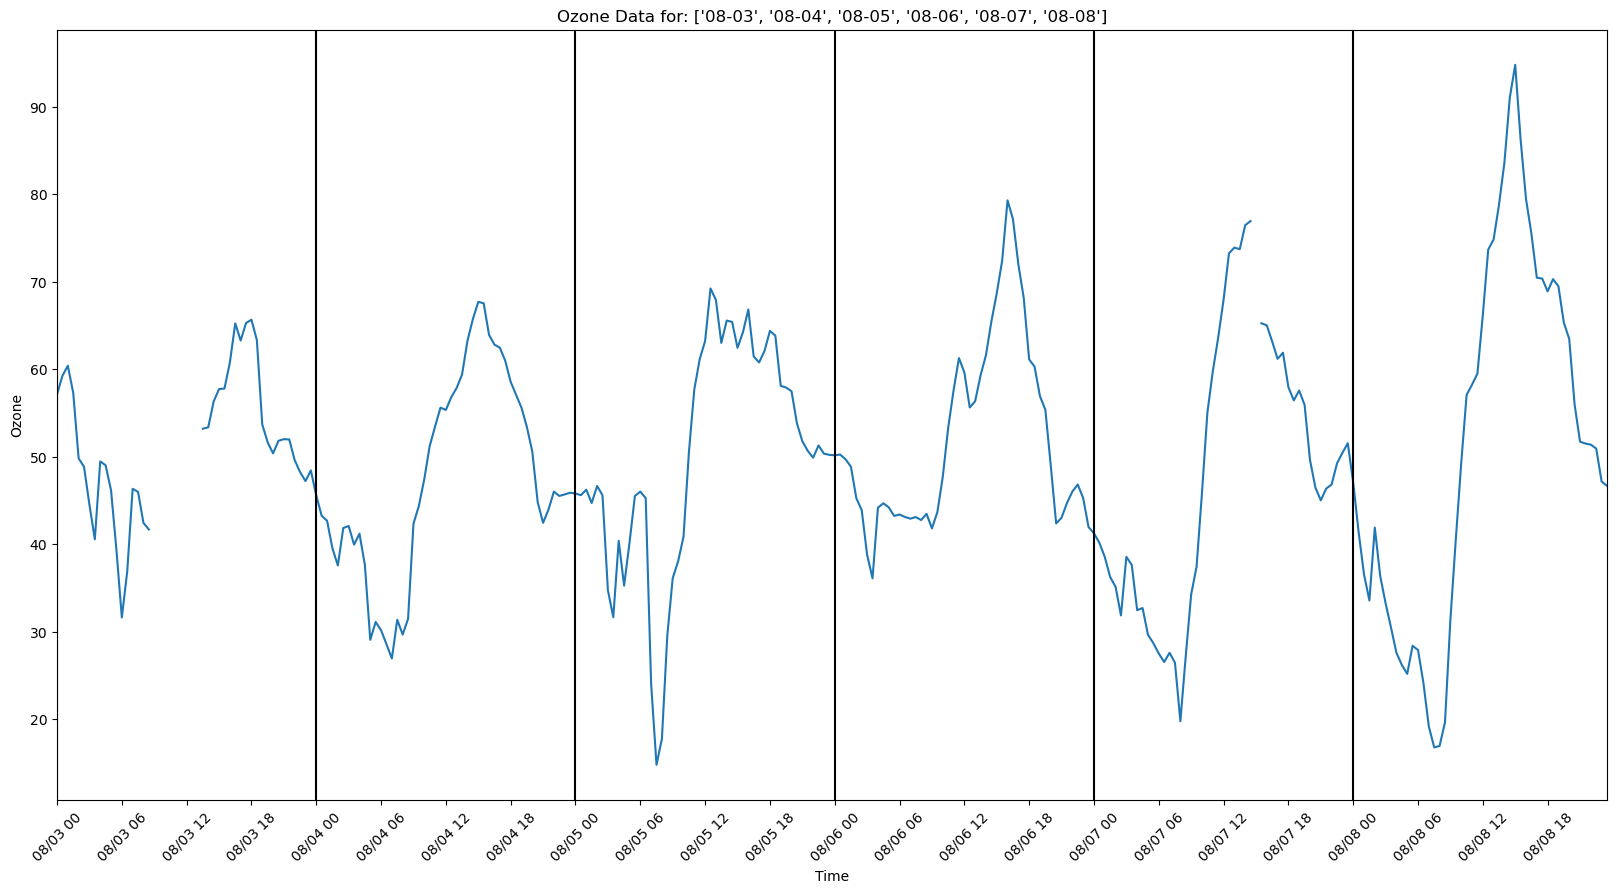

In [7]:
fig = plt.figure(figsize=(20, 10))

plt.plot(df_ozone_merged.index, df_ozone_merged.values)
plt.margins(x=0)

#Set x-axis intervals
ozone_ticks = []
for ozone_tick_idx in range(0,len(df_ozone_merged.index),12):
    ozone_ticks.append(df_ozone_merged.index[ozone_tick_idx])
plt.xticks(ticks=ozone_ticks, labels=df_ozone_merged.index.strftime('%m/%d %H')[0::12], rotation = 45)

#Draw vertical black line at midnight to distinguish the days
midnight_vals = []
for midnight_idx in range(0,len(df_ozone_merged.index),48):
    midnight_vals.append(df_ozone_merged.index[midnight_idx])
for day_pos in midnight_vals:
    plt.axvline(day_pos, color = 'black')

plt.xlabel('Time')
plt.ylabel('Ozone')
plt.title('Ozone Data for: ' + str(subset_days))

---

# MDA8 Ozone All Days

In [9]:
#load file for all dates
all_days_filepath = '../CampaignData_and_Merges/R0/CSL_MobileLab_Parked/merged/rev_30min/all_CSL_MobileLab_Parked_rev30minv4.nc'
all_days_filepath_load = xr.open_dataset(all_days_filepath)
df_alldays = all_days_filepath_load.to_dataframe()
df_alldays.set_index('time_local', inplace=True)

In [10]:
#Where are the NaNs? This will help us choose which days to cut off in the beginning
for o3_val in range(0,len(df_alldays['O3_ppbv'])):
    nan_check = np.isnan(df_alldays['O3_ppbv'].values[o3_val])
    if nan_check == True:
        print(df_alldays.index[o3_val])

2024-07-14 18:00:00
2024-07-14 18:30:00
2024-07-14 19:00:00
2024-07-14 19:30:00
2024-07-14 20:00:00
2024-07-14 20:30:00
2024-07-14 21:00:00
2024-07-14 21:30:00
2024-07-14 22:00:00
2024-07-14 22:30:00
2024-07-14 23:00:00
2024-07-14 23:30:00
2024-07-15 00:00:00
2024-07-15 00:30:00
2024-07-15 01:00:00
2024-07-15 01:30:00
2024-07-15 02:00:00
2024-07-15 02:30:00
2024-07-15 03:00:00
2024-07-15 03:30:00
2024-07-15 04:00:00
2024-07-15 04:30:00
2024-07-15 05:00:00
2024-07-15 05:30:00
2024-07-15 06:00:00
2024-07-15 06:30:00
2024-07-15 07:00:00
2024-07-15 07:30:00
2024-07-15 08:00:00
2024-07-15 08:30:00
2024-07-15 09:00:00
2024-07-15 09:30:00
2024-07-15 10:00:00
2024-07-15 10:30:00
2024-07-15 11:00:00
2024-07-15 11:30:00
2024-07-15 12:00:00
2024-07-15 12:30:00
2024-07-15 13:00:00
2024-07-15 13:30:00
2024-07-15 14:00:00
2024-07-15 14:30:00
2024-07-15 15:00:00
2024-07-15 15:30:00
2024-07-15 16:00:00
2024-07-15 16:30:00
2024-07-15 17:00:00
2024-07-15 17:30:00
2024-07-15 18:00:00
2024-07-15 18:30:00


In [13]:
#From the last cell, we see that we only have data starting on 2024-07-16 10:00:00. Before that is all Nans. So we cut off the beginning:
df_adjuststart = df_alldays.sort_index().loc["2024-07-16 10:00:00":"2024-08-18 17:30:00"]
df_adjuststart_ozone = df_adjuststart['O3_ppbv'].to_frame()

df_july_ozone = df_adjuststart_ozone.sort_index().loc["2024-07-16 10:00:00":"2024-07-31 23:30:00"]
df_july_adjuststart_ozone = df_july_ozone['O3_ppbv'].to_frame()

df_august_ozone = df_adjuststart_ozone.sort_index().loc["2024-08-01":"2024-08-18 17:30:00"]
df_august_adjuststart_ozone = df_august_ozone['O3_ppbv'].to_frame()

#Split into July, August, and a combined version because the timeline is too long to set for a single graph (it's hard to see the interpolation points)

Now we will interpolate any negative and Nan data

In [14]:
#Count how many total Nans and negative points there are
n_baddies_total= len([item for item in df_adjuststart_ozone['O3_ppbv'] if item <0 or np.isnan(item)])
n_baddies_july= len([item for item in df_july_adjuststart_ozone['O3_ppbv'] if item <0 or np.isnan(item)])
n_baddies_august= len([item for item in df_august_adjuststart_ozone['O3_ppbv'] if item <0 or np.isnan(item)])

#make a new column for interpolation, also setting any negatives to NaNs
df_adjuststart_ozone['O3_ppbv_interp'] = df_adjuststart_ozone['O3_ppbv'].mask(df_adjuststart_ozone['O3_ppbv'] < 0, np.nan)
df_july_adjuststart_ozone['O3_ppbv_interp'] = df_july_adjuststart_ozone['O3_ppbv'].mask(df_july_adjuststart_ozone['O3_ppbv'] < 0, np.nan)
df_august_adjuststart_ozone['O3_ppbv_interp'] = df_august_adjuststart_ozone['O3_ppbv'].mask(df_august_adjuststart_ozone['O3_ppbv'] < 0, np.nan)

#Where we have a NaN, print the index so that we can identify what times we are interpolating for
for o3_val in range(0,len(df_adjuststart_ozone['O3_ppbv_interp'])):
    nan_check = np.isnan(df_adjuststart_ozone['O3_ppbv_interp'].values[o3_val])
    if nan_check == True:
        print(df_adjuststart_ozone.index[o3_val])

2024-07-18 13:30:00
2024-07-18 14:00:00
2024-07-18 14:30:00
2024-07-18 15:00:00
2024-07-18 15:30:00
2024-07-18 16:00:00
2024-07-18 16:30:00
2024-07-18 17:00:00
2024-07-18 17:30:00
2024-07-22 12:00:00
2024-07-22 12:30:00
2024-07-22 13:00:00
2024-07-22 13:30:00
2024-07-22 14:00:00
2024-07-22 14:30:00
2024-07-22 15:00:00
2024-07-22 15:30:00
2024-07-22 16:00:00
2024-07-22 16:30:00
2024-07-22 17:00:00
2024-07-22 17:30:00
2024-07-22 18:00:00
2024-07-23 12:00:00
2024-07-23 12:30:00
2024-07-23 13:00:00
2024-07-23 13:30:00
2024-07-23 14:00:00
2024-07-23 14:30:00
2024-07-23 15:00:00
2024-07-23 15:30:00
2024-07-23 16:00:00
2024-07-26 10:00:00
2024-07-26 10:30:00
2024-07-26 11:00:00
2024-07-26 11:30:00
2024-07-26 12:00:00
2024-07-26 12:30:00
2024-07-26 13:00:00
2024-07-26 13:30:00
2024-07-26 14:00:00
2024-07-26 14:30:00
2024-07-26 15:00:00
2024-07-28 10:00:00
2024-07-28 10:30:00
2024-07-28 11:00:00
2024-07-28 11:30:00
2024-07-28 12:00:00
2024-07-28 12:30:00
2024-07-28 13:00:00
2024-07-28 13:30:00


In [15]:
#We interpolate all the NaNs
df_adjuststart_ozone['O3_ppbv_interp']  = df_adjuststart_ozone['O3_ppbv_interp'].interpolate(method='linear')
df_july_adjuststart_ozone['O3_ppbv_interp']  = df_july_adjuststart_ozone['O3_ppbv_interp'].interpolate(method='linear')
df_august_adjuststart_ozone['O3_ppbv_interp']  = df_august_adjuststart_ozone['O3_ppbv_interp'].interpolate(method='linear')

Text(0.5, 1.0, 'Interpolation for Ozone in July')

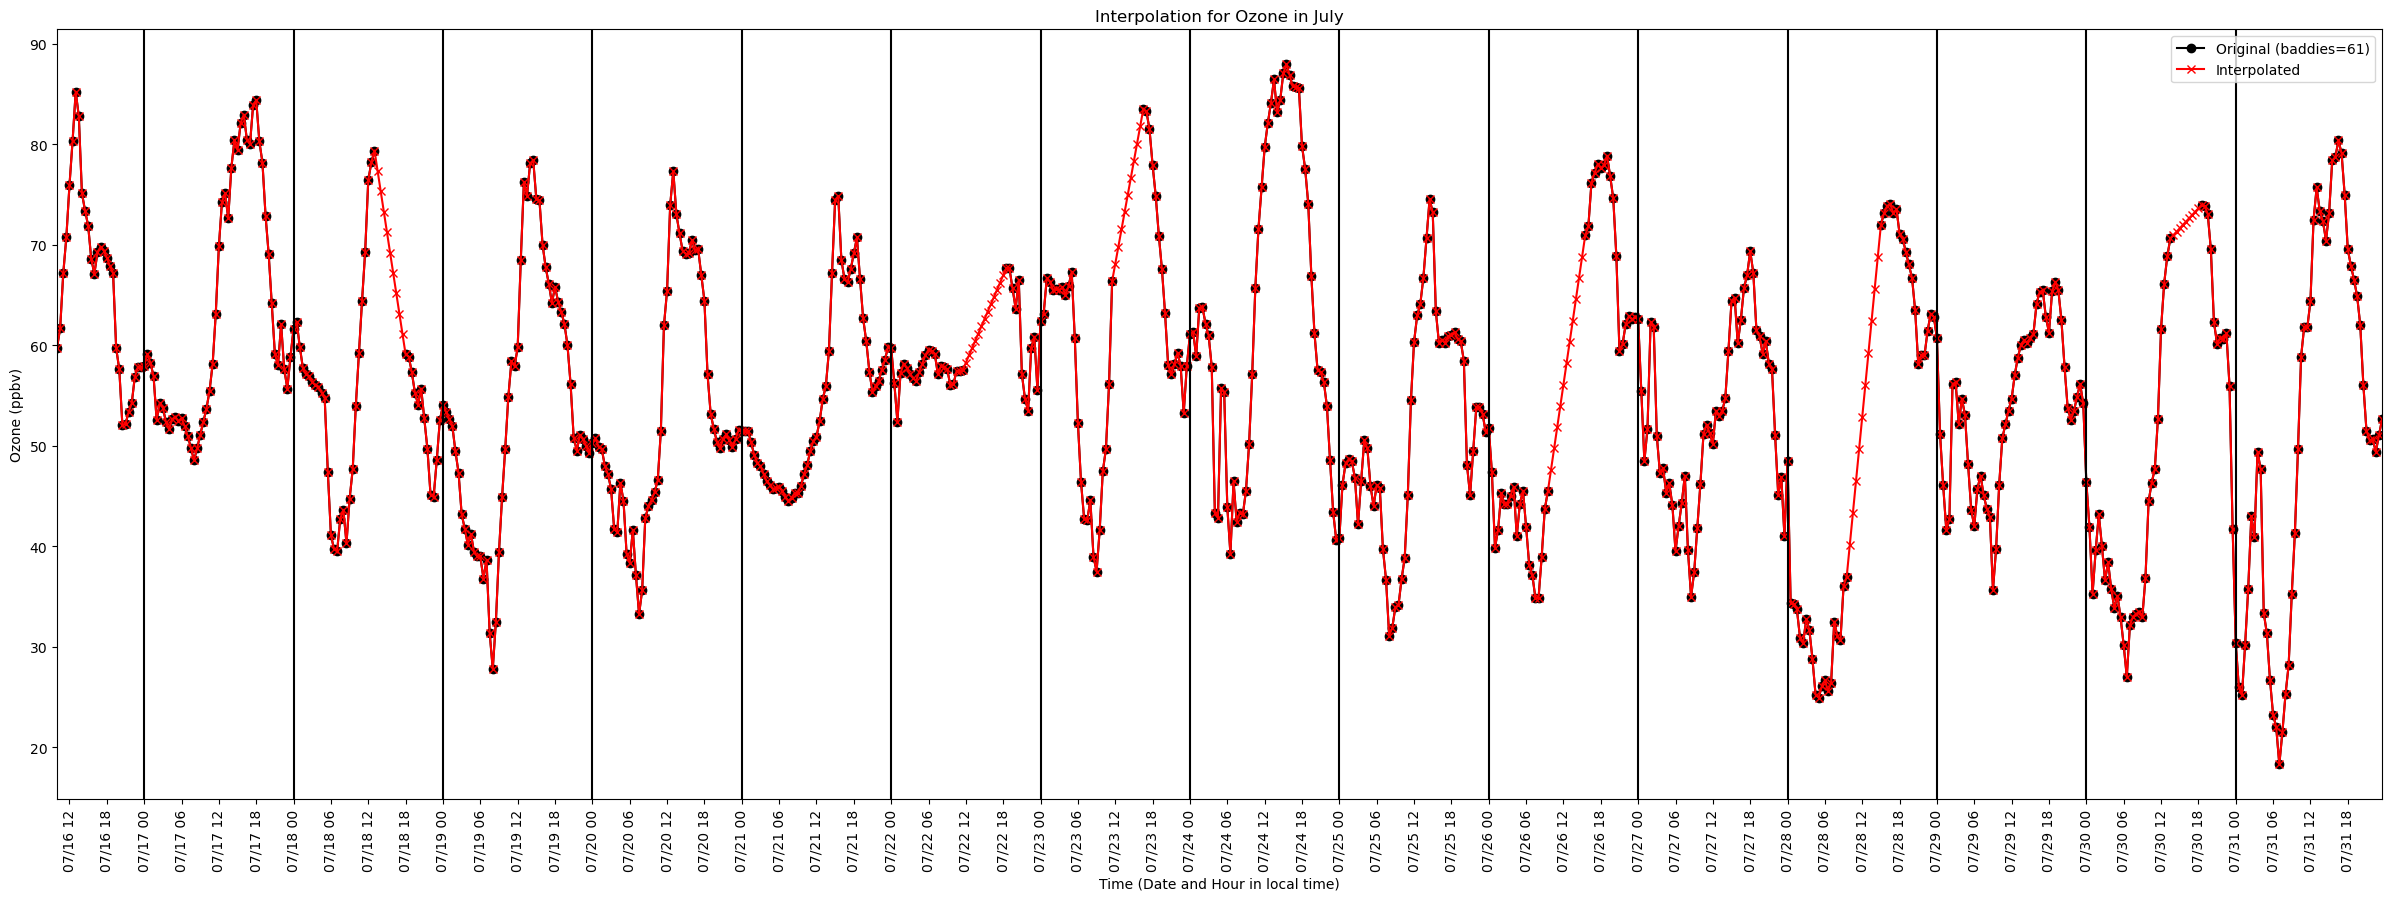

In [16]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(df_july_adjuststart_ozone.index, df_july_adjuststart_ozone['O3_ppbv'], color='k', marker='o',label=f'Original (baddies={n_baddies_july})')
plt.plot(df_july_adjuststart_ozone.index, df_july_adjuststart_ozone['O3_ppbv_interp'], color='r', marker='x', label='Interpolated')

#Set x-axis intervals
ozone_ticks = []
for ozone_tick_idx in range(4,len(df_july_adjuststart_ozone.index),12):
    ozone_ticks.append(df_july_adjuststart_ozone.index[ozone_tick_idx])
    
plt.xticks(ticks=ozone_ticks, labels=df_july_adjuststart_ozone.index.strftime('%m/%d %H')[4::12], rotation = 90)

# #Draw vertical black line at midnight to distinguish the days
midnight_vals = []
for midnight_idx in range(28,len(df_july_adjuststart_ozone.index),48):
    midnight_vals.append(df_july_adjuststart_ozone.index[midnight_idx])
for day_pos in midnight_vals:
    plt.axvline(day_pos, color = 'black')

plt.margins(x=0)
plt.xlabel('Time (Date and Hour in local time)')
plt.ylabel('Ozone (ppbv)')

plt.legend()
plt.title('Interpolation for Ozone in July')

Text(0.5, 1.0, 'Interpolation for Ozone in August')

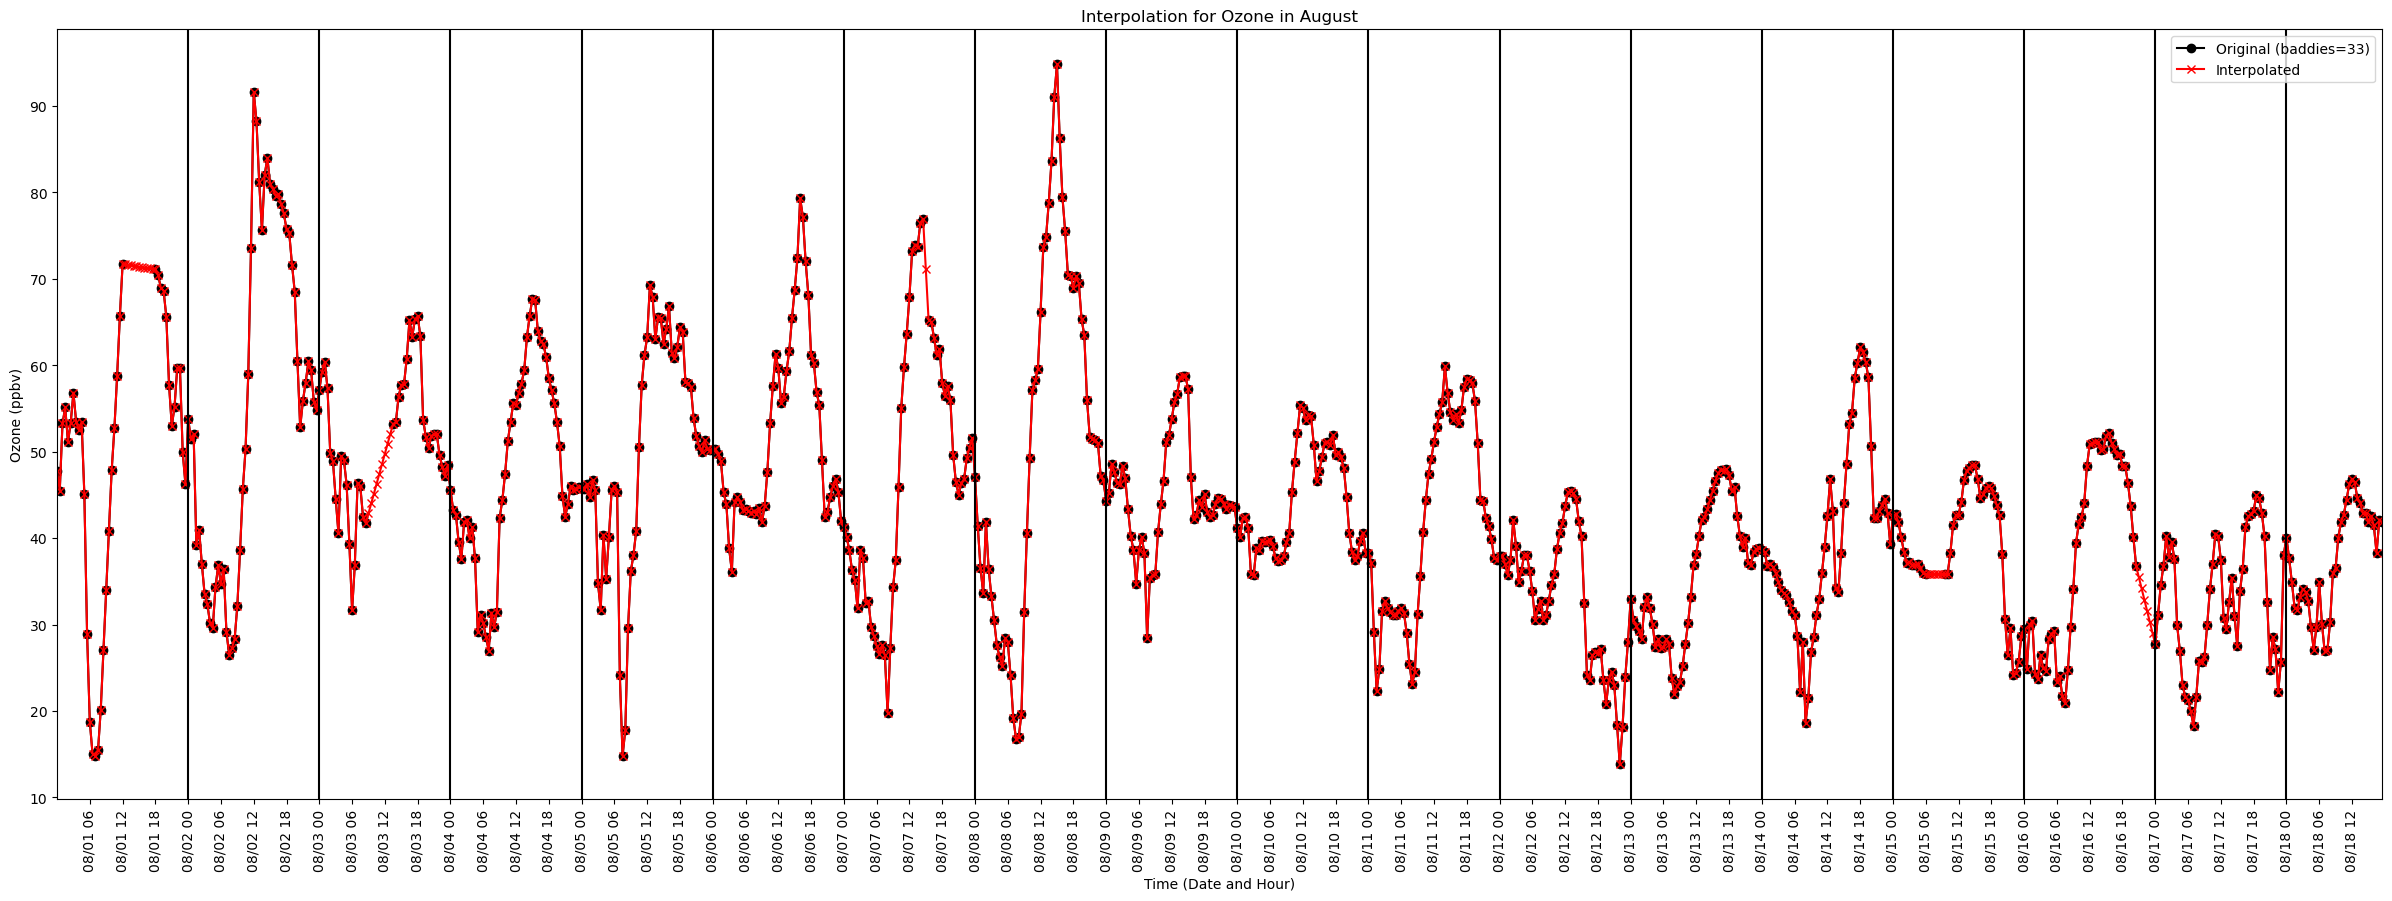

In [12]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(df_august_adjuststart_ozone.index, df_august_adjuststart_ozone['O3_ppbv'], color='k', marker='o',label=f'Original (baddies={n_baddies_august})')
plt.plot(df_august_adjuststart_ozone.index, df_august_adjuststart_ozone['O3_ppbv_interp'], color='r', marker='x', label='Interpolated')

#Set x-axis intervals
ozone_ticks = []
for ozone_tick_idx in range(12,len(df_august_adjuststart_ozone.index),12):
    ozone_ticks.append(df_august_adjuststart_ozone.index[ozone_tick_idx])
    
plt.xticks(ticks=ozone_ticks, labels=df_august_adjuststart_ozone.index.strftime('%m/%d %H')[12::12], rotation = 90)

# #Draw vertical black line at midnight to distinguish the days
midnight_vals = []
for midnight_idx in range(48,len(df_august_adjuststart_ozone.index),48):
    midnight_vals.append(df_august_adjuststart_ozone.index[midnight_idx])
for day_pos in midnight_vals:
    plt.axvline(day_pos, color = 'black')

plt.margins(x=0)
plt.xlabel('Time (Date and Hour)')
plt.ylabel('Ozone (ppbv)')

plt.legend()
plt.title('Interpolation for Ozone in August')

In [17]:
# Step 1: Calculate the 8-hour rolling average
df_adjuststart_ozone['O3_8hr_avg'] = df_adjuststart_ozone['O3_ppbv_interp'].rolling(window=16, min_periods=16).mean()
#rolling average only works for 8 hours with no gaps; at least 6 hours
#print(df_adjuststart_hourly_ozone)

# Step 2: Calculate the maximum 8-hour average for each day
# Resample to daily frequency, compute the daily max of the rolling averages, drop NA values
adjuststart_daily_max_8hr_avg_ozone = df_adjuststart_ozone['O3_8hr_avg'].resample('D').max().dropna()
#print('Max 8 hr avg each day:\n', adjuststart_daily_max_8hr_avg_ozone)

# Step 3: Map the daily maximum back to the original dataframe
# Create a new temporary column with the daily max 8-hour average for each timestamp
df_adjuststart_ozone['MDA8_O3'] = df_adjuststart_ozone.index.floor('D').map(adjuststart_daily_max_8hr_avg_ozone)
#print('Daily max 8 hour avg for each timestamp: \n', df_adjuststart_hourly_ozone['MDA8_O3'])

# Select daytime values only where MD8A > 65
df_ozone_day_exceedance = df_adjuststart_ozone[(df_adjuststart_ozone.index.hour >=7) & (df_adjuststart_ozone.index.hour<=20) & (df_adjuststart_ozone['MDA8_O3']>65)]
#print('When is MDA8 > 65?\n', df_ozone_day_exceedance)

[Timestamp('2024-07-16 12:00:00'), Timestamp('2024-07-16 18:00:00'), Timestamp('2024-07-17 00:00:00'), Timestamp('2024-07-17 06:00:00'), Timestamp('2024-07-17 12:00:00'), Timestamp('2024-07-17 18:00:00'), Timestamp('2024-07-18 00:00:00'), Timestamp('2024-07-18 06:00:00'), Timestamp('2024-07-18 12:00:00'), Timestamp('2024-07-18 18:00:00'), Timestamp('2024-07-19 00:00:00'), Timestamp('2024-07-19 06:00:00'), Timestamp('2024-07-19 12:00:00'), Timestamp('2024-07-19 18:00:00'), Timestamp('2024-07-20 00:00:00'), Timestamp('2024-07-20 06:00:00'), Timestamp('2024-07-20 12:00:00'), Timestamp('2024-07-20 18:00:00'), Timestamp('2024-07-21 00:00:00'), Timestamp('2024-07-21 06:00:00'), Timestamp('2024-07-21 12:00:00'), Timestamp('2024-07-21 18:00:00'), Timestamp('2024-07-22 00:00:00'), Timestamp('2024-07-22 06:00:00'), Timestamp('2024-07-22 12:00:00'), Timestamp('2024-07-22 18:00:00'), Timestamp('2024-07-23 00:00:00'), Timestamp('2024-07-23 06:00:00'), Timestamp('2024-07-23 12:00:00'), Timestamp('20

Text(0.5, 1.0, 'MDA8 Ozone during USOS')

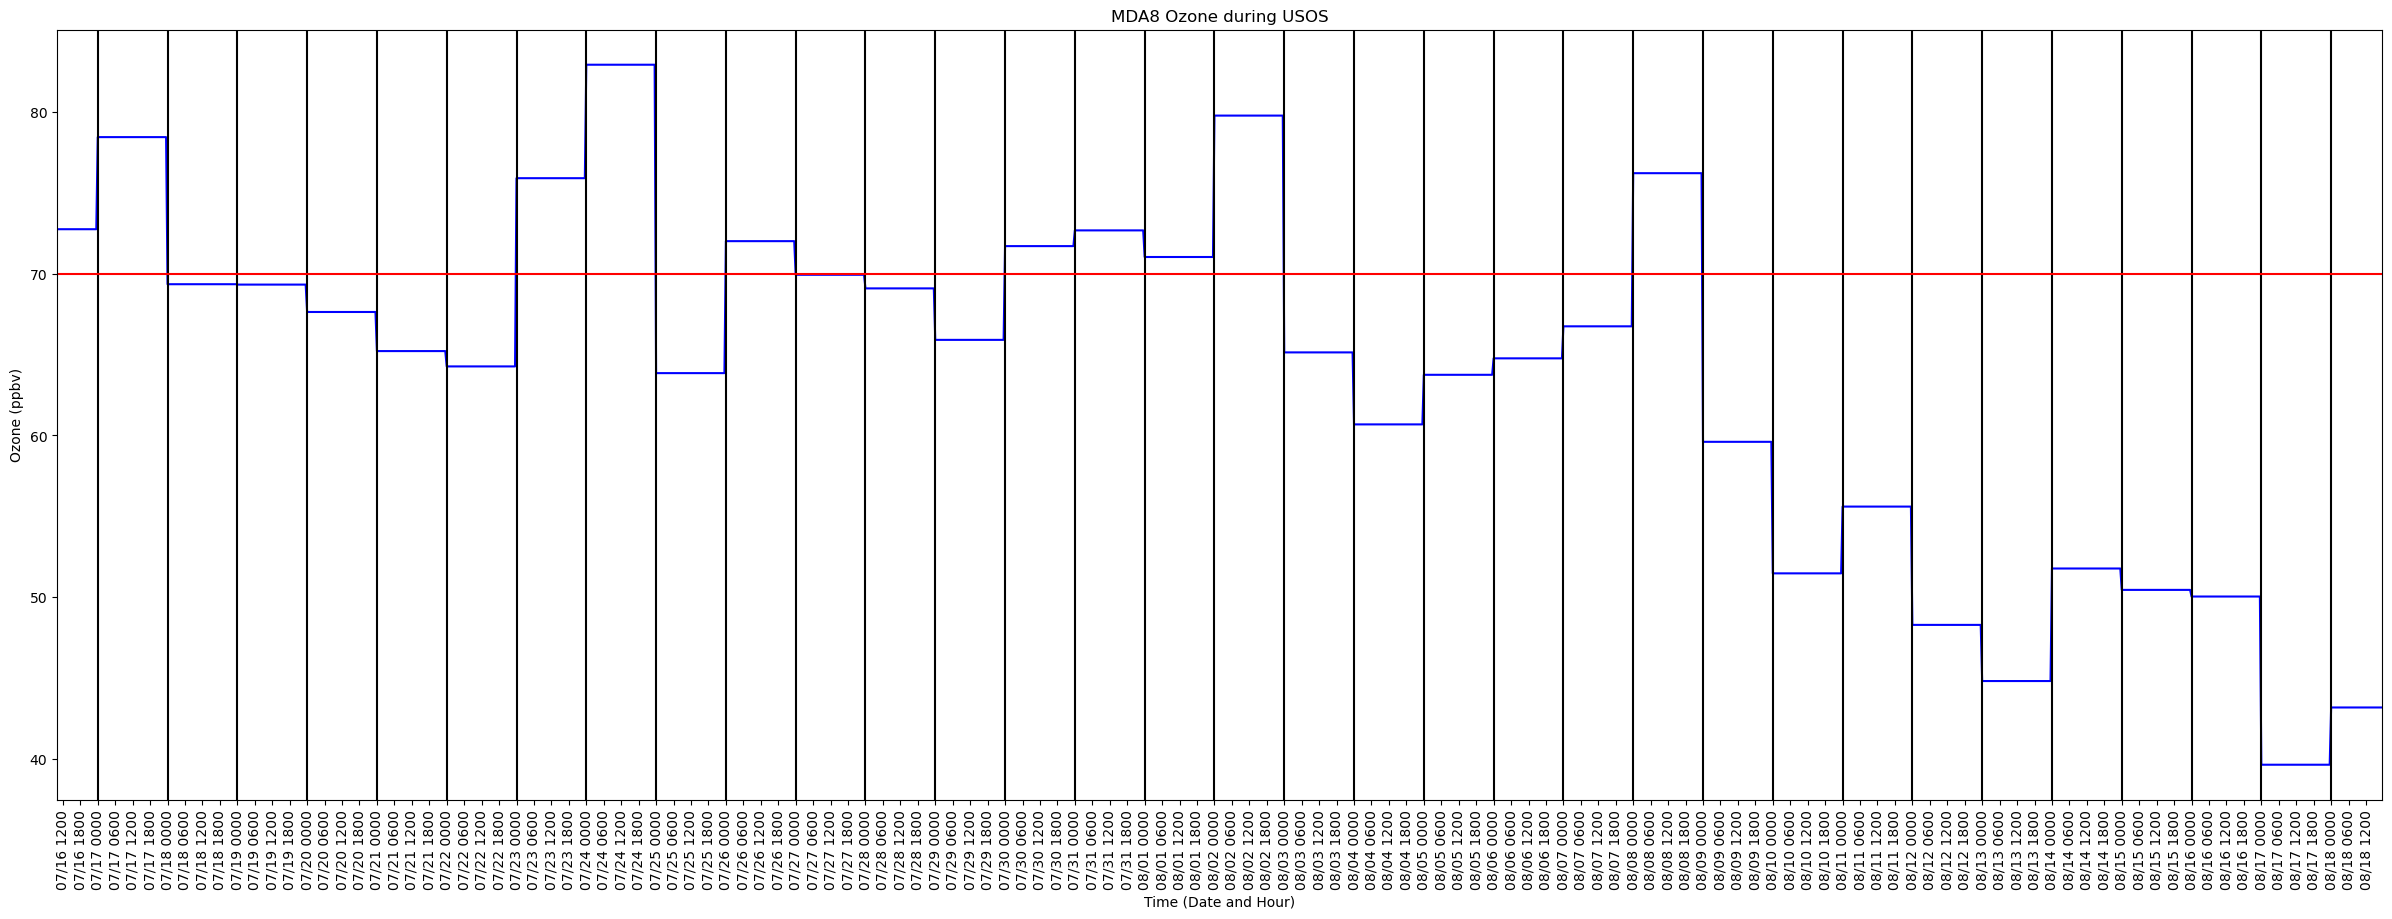

In [18]:
fig, ax = plt.subplots(figsize = (30,10))
plt.plot(df_adjuststart_ozone.index, df_adjuststart_ozone['MDA8_O3'], color='b')
plt.margins(x=0)

#Set x-axis intervals
ozone_ticks = []
for ozone_tick_idx in range(4,len(df_adjuststart_ozone.index),12):
    ozone_ticks.append(df_adjuststart_ozone.index[ozone_tick_idx])
print(ozone_ticks)
plt.xticks(ticks=ozone_ticks, labels=df_adjuststart_ozone.index.strftime('%m/%d %H%M')[4::12], rotation = 90)

midnight_vals = []
for midnight_idx in range(28,len(df_adjuststart_ozone.index),48):
    midnight_vals.append(df_adjuststart_ozone.index[midnight_idx])
for day_pos in midnight_vals:
    plt.axvline(day_pos, color = 'black')

plt.hlines(y=70, xmin = df_adjuststart_ozone['MDA8_O3'].index[0], xmax = df_adjuststart_ozone['MDA8_O3'].index[len(df_adjuststart_ozone['MDA8_O3'])-1], color = 'r')
plt.xlabel('Time (Date and Hour)')
plt.ylabel('Ozone (ppbv)')

plt.title('MDA8 Ozone during USOS')

---

## Switching into a plot that only has one point per day

In [19]:
df_daily_max_8hr_avg_ozone= adjuststart_daily_max_8hr_avg_ozone.to_frame(name='O3_daily_max_8hr_avg')

Text(0.5, 1.0, 'MDA8 Ozone for 30 min resolutions during USOS')

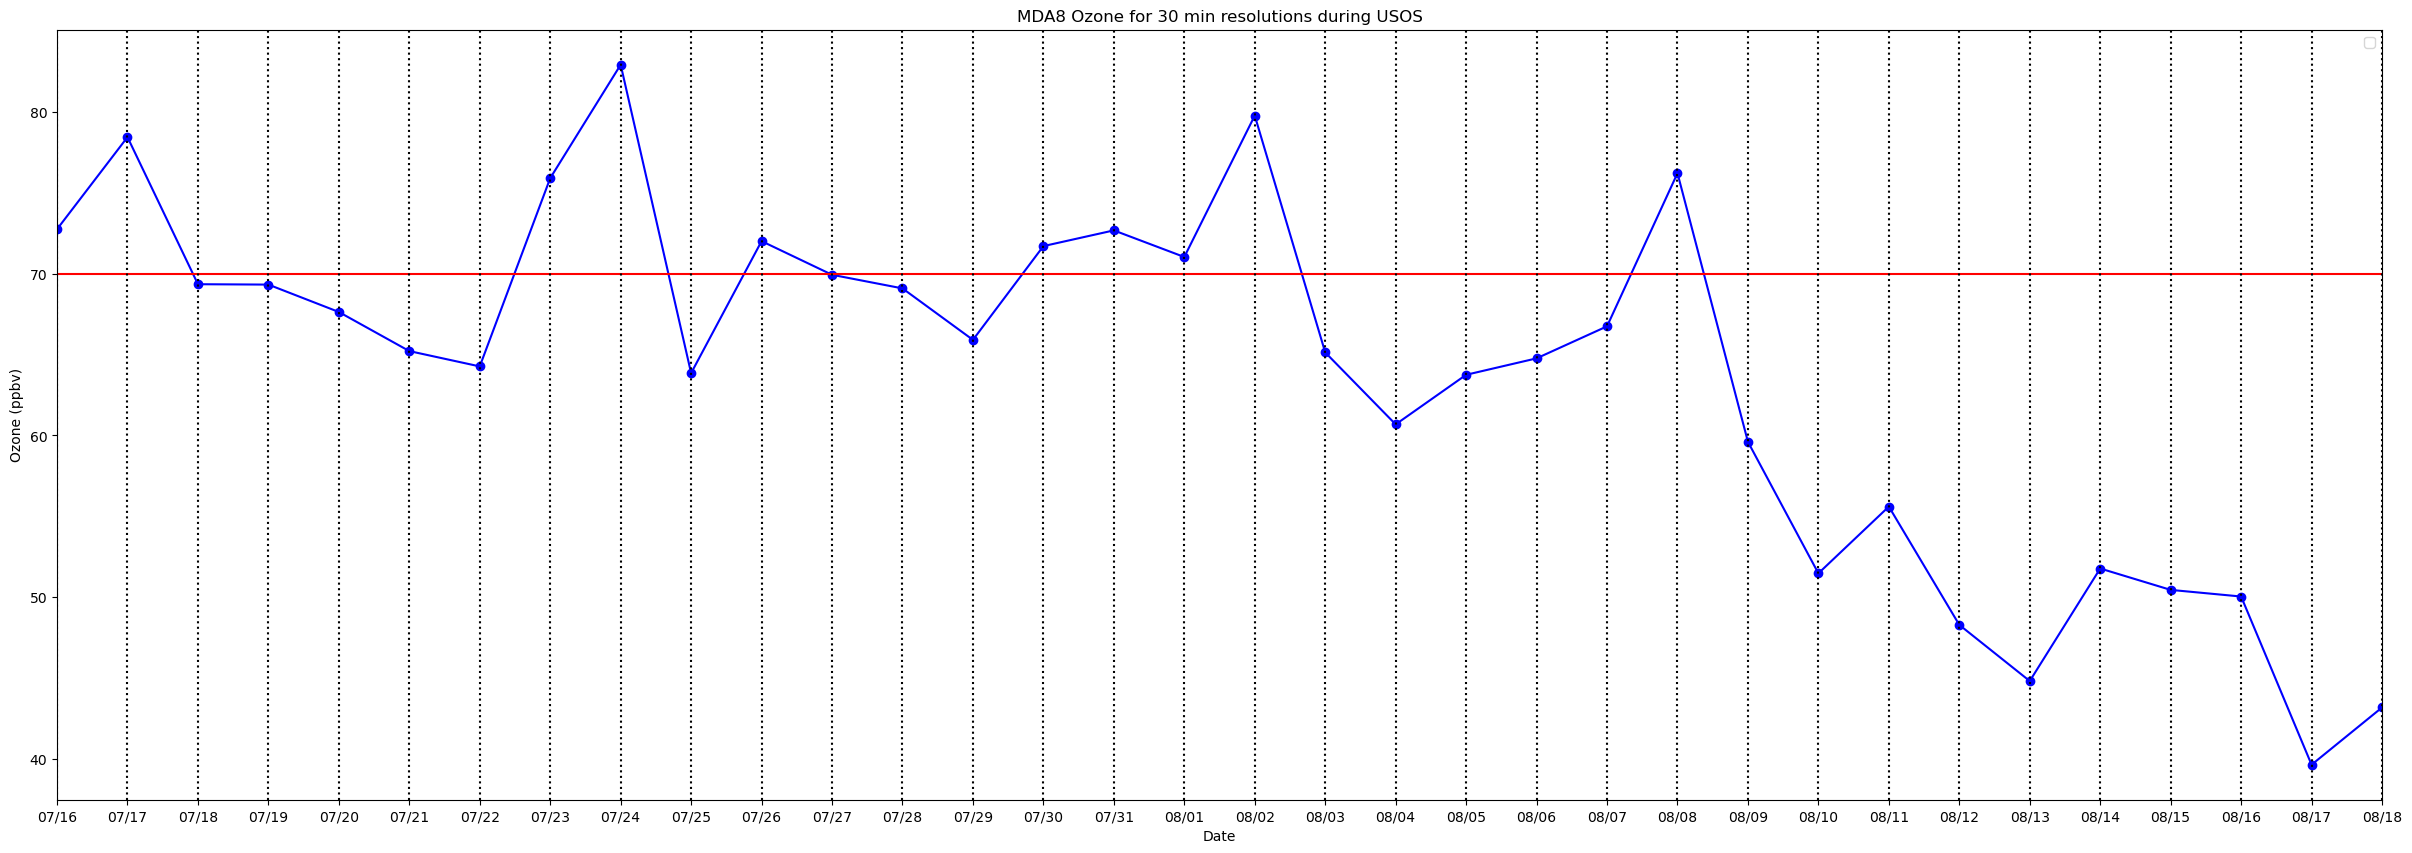

In [20]:
fig, ax1 = plt.subplots(figsize = (30,10))

ax1.margins(x=0)

ax1.plot(df_daily_max_8hr_avg_ozone.index, df_daily_max_8hr_avg_ozone['O3_daily_max_8hr_avg'], color='b',marker='o')

ax1.set_ylabel('Ozone (ppbv)')
ax1.set_xlabel('Date')

ax1.hlines(y=70, xmin = df_daily_max_8hr_avg_ozone['O3_daily_max_8hr_avg'].index[0], xmax = df_daily_max_8hr_avg_ozone['O3_daily_max_8hr_avg'].index[len(df_daily_max_8hr_avg_ozone['O3_daily_max_8hr_avg'])-1], color = 'r')

ax1.set_xticks(df_daily_max_8hr_avg_ozone.index)
ax1.set_xticklabels(df_daily_max_8hr_avg_ozone.index.strftime('%m/%d'))

# midnight_vals_30min = []
# for midnight_idx_30min in range(16,len(df_adjuststart_30min_ozone.index),48):
#     midnight_vals_30min.append(df_adjuststart_30min_ozone.index[midnight_idx_30min])
for day_pos_30min in df_daily_max_8hr_avg_ozone.index:
    ax1.axvline(day_pos_30min, color = 'black', linestyle = 'dotted')


lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines, labels, loc=0)
plt.title('MDA8 Ozone for 30 min resolutions during USOS')

We can see that the days that are passing the MDA8 ozone of 70 ppbv are:
* 7/16, 7/17
 <br/> 

* 7/23, 7/24
 <br/> 

* 7/26
 <br/> 

* 7/30, 7/31, 8/01, 8/02
 <br/> 

* 8/08